## ТЗ
Вам необходимо решить модельный бизнес кейс от некоторого заказчика - строительной компании, которая занимается возведением многоквартирных домов.

Заказчику необходимо подсчитать сколько в уже построенном районе находится окон в жилых зданиях, а также количество этажей в здании и количество колонн (вертикальных рядов окон)

Также заказчик хотел бы выделять на фото фасад "главного" здания, если на изображении несколько зданий)

Вам необходимо:

1. Сделать обзор всевозможных решений решений по применению ИИ в строительстве, проектировании и эксплуатации и продажи квартир, показать вашу экспертизу и подготовку
2. Провести описание подходов, которые вы планируете использовать для решения задачи
3. Собрать датасет на котором изображены многоквартирные жилые дома, либо использовать синтетические данные
4. Провести необходимую для вас разметку датасета (сегментация фасада, окна)
5. САМЫЙ ВАЖНЫЙ ПУНКТ - обучить собственный алгоритм (pytorch, tensorflow) сегментации фасада главного здания, а также алгоритм определения числа окон, числа этажей и числа колонн на выбор, можно решить несколько). То есть сегментация + одна из задач по подсчёту.
6. Составить презентацию и ноутбук с результатами, выложить на гитхаб
7. Прислать ссылку на решение и резюме в телеграм @frankshikhaliev
8. Также заполнить форму
https://docs.google.com/forms/d/e/1FAIpQLSfkavbuwPY20eQVS_dx7daQBGoBnDlGRtbfWzMKdi_tOFUkYg/viewform
Срок выполнения - 10 дней

## Обзор решений по применению ИИ в строительстве

## Используемый подход
### Dataset
В качестве датасета был взять CMP Facade Dataset с 11 классами (не считая background) и из этих 11 классов было взято 3:
- facade 
- window 
- pillar

Также были проведены эксперементы по созданию синтетического датасета с использованием Stable Diffusion совместно с [Lora Facades](https://civitai.com/models/11661/buildingfacade) в режиме img2img/sketch. К сожалению, времени на создание синтетического датасета не хватило.

### Model
Данную задачу можно решить на уровне модели DL, как:
1. Semantic segmentation. То есть подсчёт окон, колонн и фасадов будет осуществляться с использованием классических алгоритмов сегментации CV.
    - Этот подход выглядит более простым в реализации, потому что для данной задачи существуют готовые датасеты размечены именно под эту задачу (используемый мной в том числе).
    - Для этого можно использовать следующие модели:
        - **UNet** \[Используется\] - классический подход Encoder + Skip Connections + Decoder. В качестве backbone используется resnet34.
        - DeepLabV3+ - соврменный подход Delited Convolutions + Pyramid Pooling + Encoder/Decoder + Interpolation (Не успел зафайтюнить, а с дефолотными значениями сходится хуже Unet). 
        - Hierarchical Multi-scale Attention + Model. Позволяет агрегировать маски с разных скейлов, тем самым улучшая результат сегментации (Также мысли для дальнейшего ресёрча).
2. Instance segmentation.
    - end2end подход (практически).
    - Мне он видется более естественным подходом для данной задачи так, как существует подсчёт объектов 
    - Используемый датасет ближе к Object Detection разметке чем к Segmentation, поэтому используемые для Instance Segmentation алгоритмы более естественны.
    - Для этого можно использовать следующие алгоритмы:
        - Mask-RCNN \[Используется\]
        - YOLOv5seg (Не успел проверить)

Датасет является сильно несбалансированным, поэтому в качестве функции потерь будет использоваться FocalTverskyLoss с gamma=2, alpha=beta=.5.

С учётом того, что основная разметка и задача состоит в подсчёте раздельных объектов её более естественно решать, как задачу Instance segmentation, но т.к. в ТЗ просят обучить собственный алгоритм (пункт 5), то я решу также задачу с помощь классической архитектуры Unet и постараюсь её зафайтюнить под данную задачу. В данном ноутбуке я решаю задачу с помощью архитектуры Unet и библиотек pytorch + semantic_segmentation_models + pytorch_lightning.

### Postprocessing
В качестве постпроцессинга использовалась обычная очистка от шумов, а также связные компоненты для разделение объектов и последующего их подсчёта ([guide OpenCV](https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html)).

## Experiments with Stable Diffsuion
Как упоминалось выши для синтезы датасета использовалась Lora обученная на данном датасете. Была проведено два эксперемента по генерации новых примеров:
1. На уже существующей разметке был использован ControlNet для извлечения с исходного карты глубины исходного изображения и последующего его применения в генерации. Оказалась более продуктивен - сохранялось число окон, но были проблемы с дверьми и колоннами.
2. На созданной в ручную (лекго генерируемой) разметке. Результат оказался хуже, терялось число объектов и сгенерированные объекты плохо соответсвовали разметке. 

Качество изображений, даже без сильного файтюнинга промта оказалось весьма хорошим и более половины изображений были реалистичными. Для утдверждения о качестве данного подхода нужно больше эксперементов и исследований. 

Но, я считаю, что если доработать создание разметки, сделав её более детальной, а также улучшить промпт, то можно добиться высокачественной генерации примеров по разметке.

Примеры генераций можно увидеть в репоризитории.

## Collect Dataset

In [1]:
!wget https://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_base.zip
!wget https://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_extended.zip

--2023-03-16 12:09:59--  https://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_base.zip
Resolving cmp.felk.cvut.cz (cmp.felk.cvut.cz)... 147.32.84.2
Connecting to cmp.felk.cvut.cz (cmp.felk.cvut.cz)|147.32.84.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36517004 (35M) [application/zip]
Saving to: ‘CMP_facade_DB_base.zip’

CMP_facade_DB_base. 100%[===================>]  34.83M  15.0MB/s    in 2.3s    

2023-03-16 12:10:02 (15.0 MB/s) - ‘CMP_facade_DB_base.zip’ saved [36517004/36517004]

--2023-03-16 12:10:02--  https://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_extended.zip
Resolving cmp.felk.cvut.cz (cmp.felk.cvut.cz)... 147.32.84.2
Connecting to cmp.felk.cvut.cz (cmp.felk.cvut.cz)|147.32.84.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20309906 (19M) [application/zip]
Saving to: ‘CMP_facade_DB_extended.zip’

CMP_facade_DB_exten 100%[===================>]  19.37M  12.0MB/s    in 1.6s    

2023-03-16 12:10:04 (12.0 MB/s) 

In [2]:
!mkdir CMP_Facades -p
# Unzip archives in CMP_Facades with no replacement.
!unzip -q -n /content/CMP_facade_DB_base.zip -d /content/CMP_Facades
!unzip -q -n /content/CMP_facade_DB_extended.zip -d /content/CMP_Facades

In [3]:
!pip install pytorch_lightning
!pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.6/715.6 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 715.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 9.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 9.0 MB/s eta 0:00

In [4]:
import os
from glob import glob
import numpy as np
import pandas as pd
import torch
import pytorch_lightning as pl
from PIL import Image
import cv2
from IPython.display import display, clear_output
import matplotlib.pyplot as plt 

XML mask reader

In [5]:
target_classes = [
    "facade",
    "window",
    "pillar",
]

In [6]:
import xml.etree.ElementTree as ET
import re


def read_label_list(label_list_path):
    """Return dict label_index : label_name"""
    label_list = {}
    with open(label_list_path) as f:
        for line in f.readlines():
            label_index, label_name, label_order = line.split(" ")
            # for label index started from zero
            label_list[int(label_index) - 1] = label_name
    return label_list

def read_xml_mask(mask_path):
    """Read XML file with objects

    Attrs
    - mask_path: str

    Return list of dict that contain:
        - points (x: float, y: float), 
        - label: int, 
        - label_name: str
    """
    with open(mask_path) as f:
        xml = f.read()
    root = ET.fromstring("<root>" + xml + "</root>")
    objects = []
    for obj in root.findall("object"):
        points = obj.find("points")
        points = [
            (float(x.text), float(y.text))
            for y, x in zip(points.findall("x"), points.findall("y"))
            ]
        label = int(obj.find("label").text)
        label_name = obj.find("labelname").text
        # for label index starting from zero
        objects.append({
            "points": points, 
            "label": label - 1, 
            "label_name": label_name.strip()
        })
    return objects

def xml2segmask(mask_path, label_list, size, include_classes=None):
    """XML annotaion to segmentation mask.

    Attrs
    - size: height and width
    - include_classes: is a list of classes names 
        if None then all classes is included.
    - label_f: callable is label function, that we use 
        for process label and label_name. default=None. 
    
    Return mask for the smp model
    """
    h, w = size
    objects = read_xml_mask(mask_path)
    # sort objects in the mask by order of his masks
    objects.sort(key=lambda x: x["label"])
    segmentation_mask = np.zeros(size, dtype=np.uint8)
    new_label_list = {}
    for obj in objects:
        if include_classes is None or obj["label_name"] in include_classes:
            points = np.array([(x * w, y * h) for x, y in obj["points"]])
            points = np.int32(np.round(points))
            label = obj["label"] \
                if len(label_list) == len(include_classes) else include_classes.index(obj["label_name"]) + 1
            # fill new label list
            if new_label_list.get(obj["label_name"], None) is None:
                new_label_list[obj["label_name"]] = label
            # draw object
            cv2.rectangle(segmentation_mask, points[0], points[1], color=label, thickness=-1)
            
    return segmentation_mask, new_label_list

In [7]:
CMP_PATH = "/content/CMP_Facades"

In [8]:
from sklearn.model_selection import train_test_split
seed = 42

def get_cmp_dataset_filenames(root, val_size=.2, seed=42):
    samples = []
    for dir_path in "base", "extended":
        images_paths = sorted(glob(os.path.join(root, dir_path, "*.jpg")))
        masks_paths = sorted(glob(os.path.join(root, dir_path, "*.xml")))
        samples += [{"image": img, "mask": mask} for img, mask in zip(images_paths, masks_paths)]
    samples = pd.DataFrame(samples)
    samples["split"] = "train"
    _, val_index = train_test_split(samples.index, random_state=seed)
    samples["split"].loc[val_index] = "val"
    return samples

## Create Dataset

In [9]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

HEIGHT, WIDTH = 512, 512


train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(),
    A.SafeRotate(5, p=.2),
    A.SmallestMaxSize(max_size=HEIGHT, always_apply=True),
    A.RandomCrop(height=HEIGHT, width=WIDTH, always_apply=True),
])

In [10]:
class CMPDataset(torch.utils.data.Dataset):
    def __init__(self, root, split="train", transform=None, include_classes=None, 
                 mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
        filenames = get_cmp_dataset_filenames(CMP_PATH, seed=seed)
        self.samples = filenames[filenames["split"] == split]
        self.label_list = read_label_list(os.path.join(root, "label_names.txt"))
        
        self.base_transform = A.Compose([
            # default ImageNet settings to mean and std
            A.Normalize(mean=mean, std=std),
            # For pytorch HWC -> CHW
            ToTensorV2()
        ])
        self.transform = transform
        self.include_classes = include_classes
        self.mean = np.array(mean)
        self.std = np.array(std)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path = self.samples.iloc[idx]["image"]
        mask_path = self.samples.iloc[idx]["mask"]

        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        size = img.shape[:2]
        xml_mask = read_xml_mask(mask_path)
        mask, self.updated_label_list = xml2segmask(
            mask_path, self.label_list, size, 
            include_classes=self.include_classes
        )
        mask = np.int64(mask)

        if self.transform is not None:
            transformed = self.transform(image=img, mask=mask)
            img, mask = transformed["image"], transformed["mask"]
        
        transformed = self.base_transform(image=img, mask=mask)
        img, mask = transformed["image"], transformed["mask"]

        return img, mask.long()

    def unnorm(self, x):
        if type(x) == torch.Tensor:
            x = x.detach().cpu().numpy().squeeze()
            x = np.moveaxis(x, 0, 2)
        elif type(x) == np.ndarray:
            x = np.squeeze(x)
        else:
            raise AttributeError("x must be torch.Tensor or ndarray")
        unnorm_x = x * self.std.reshape(1, 1, 3) * 255 + self.mean.reshape(1, 1, 3) * 255
        return np.uint8(np.round(unnorm_x))

        

## Training

In [11]:
def visualize_masks(true, pred, image):
    fig, ax = plt.subplots(1, 3, figsize=(15, 45))
    ax[0].imshow(true)
    ax[1].imshow(pred)
    ax[2].imshow(image)
    plt.show()

In [12]:
import segmentation_models_pytorch as smp

In [13]:
BATCH_SIZE = 16
LR = 0.00025

In [20]:
class SegmentationFacadesModule(pl.LightningModule):
    def __init__(self, mode, include_classes):
        super().__init__()
        encoder_name = "resnet34"
        self.num_classes = len(include_classes) + 1
        self.model = smp.Unet(encoder_name=encoder_name, classes=self.num_classes)
        # using Tversky focal losses to work with highly unbalanced data
        self.criterion = smp.losses.TverskyLoss(mode, gamma=2, from_logits=True)

        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.mean, self.std = params["mean"], params["std"]
        self.epoch_start = True

        self.train_dataset = CMPDataset(
            CMP_PATH, 
            transform=train_transform, 
            split="train",
            include_classes=include_classes,
            mean=self.mean,
            std=self.std    
        )
        self.val_dataset = CMPDataset(
            CMP_PATH, 
            split="val",
            include_classes=include_classes,
            mean=self.mean,
            std=self.std,
            transform=A.Resize(HEIGHT, WIDTH)   
        )
        self.mode = "multiclass" \
            if len(include_classes) > 1 else "binary"

        assert set(self.train_dataset.samples.index).isdisjoint(set(self.val_dataset.samples.index))

        self.training_step_outputs = []
        self.val_step_outputs = []

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset, 
            batch_size=BATCH_SIZE,
            shuffle=True,
        )
  
    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset, 
            batch_size=BATCH_SIZE, 
            shuffle=False,
        )

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=LR)
        return optimizer

    def shared_step(self, batch, stage):
        images, labels = batch
        predicted_heatmaps = self.model(images)  
        loss = self.criterion(predicted_heatmaps, labels)
        prob_mask = predicted_heatmaps.softmax(1)
        pred_mask = torch.argmax(predicted_heatmaps, dim=1)
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask.long(), labels.long(), mode=self.mode,
            num_classes=self.num_classes)

        if stage == "val":
            self.val_step_outputs.append({
                "loss": loss,
                "tp": tp,
                "fp": fp,
                "fn": fn,
                "tn": tn,
            })
            # if self.epoch_start:
            #     pred = pred_mask.detach().cpu()[0]
            #     true = labels.detach().cpu()[0]
            #     image = images[0].detach().cpu()
            #     image = self.val_dataset.unnorm(image)
            #     visualize_masks(true, pred, image)
            #     self.epoch_start = False
        else:
            self.training_step_outputs.append({
                "loss": loss,
                "tp": tp,
                "fp": fp,
                "fn": fn,
                "tn": tn,
            })
        
        self.log(f"{stage}_dataset_loss", loss)

        return loss


    def shared_epoch_end(self, stage):
        outputs = self.training_step_outputs if stage == "train" else self.val_step_outputs
        tp = torch.cat([x["tp"] for x in outputs]) 
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)
        self.epoch_start = True

        outputs.clear()
            
    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")          

    def on_train_epoch_end(self):
        return self.shared_epoch_end("train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "val")

    def on_validation_epoch_end(self):
        return self.shared_epoch_end("val")

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir logs/

In [21]:
mode = "multiclass" \
            if len(target_classes) > 1 else "binary"

module = SegmentationFacadesModule(mode, target_classes)
logger = pl.loggers.TensorBoardLogger("./logs", name='test')
trainer = pl.Trainer(
    accelerator="auto",
    logger=logger,
    log_every_n_steps=10,
    max_epochs=100,
    val_check_interval=10
)
trainer.fit(module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type        | Params
------------------------------------------
0 | model     | Unet        | 24.4 M
1 | criterion | TverskyLoss | 0     
------------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.747    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [26]:
trainer.validate()

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.validate(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.validate(ckpt_path='best')` to use the best model or `.validate(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at ./logs/test/version_1/checkpoints/epoch=99-step=2891.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at ./logs/test/version_1/checkpoints/epoch=99-step=2891.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     val_dataset_iou        0.7838150858879089
    val_dataset_loss        0.07781858742237091
    val_per_image_iou       0.7906692624092102
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_dataset_loss': 0.07781858742237091,
  'val_per_image_iou': 0.7906692624092102,
  'val_dataset_iou': 0.7838150858879089}]

## Predictions with postprocessing

In [22]:
def postprocessing(mask):
    """Normalize image (remove noizes in every class with morphologyEx) 
    and return mask the same as ground truth
    """
    kernel = np.ones((3, 3), np.uint8)
    classes = list(range(mask.shape[0]))
    normalized_mask = np.zeros_like(mask)
    norms = []
    mask = mask.argmax(axis=0)
    for c in classes:
        class_mask = np.uint8(mask == c)
        norm_class_mask = cv2.morphologyEx(class_mask, cv2.MORPH_OPEN, kernel, iterations=2)
        norms.append(norm_class_mask[np.newaxis, ...])
    normalized_mask = np.concatenate(norms, axis=0)
    normalized_mask = normalized_mask.argmax(axis=0)
    return normalized_mask

def count_objects(mask):
    ret, markers = cv2.connectedComponents(mask)
    return ret - 1, markers

In [23]:
def visualize_masks_pred(true, pred, image, windows, pillars):
    fig, ax = plt.subplots(1, 5, figsize=(15, 45))
    ax[0].imshow(true)
    ax[1].imshow(pred)
    ax[2].imshow(image)
    ax[3].imshow(windows)
    ax[4].imshow(pillars)
    plt.show()

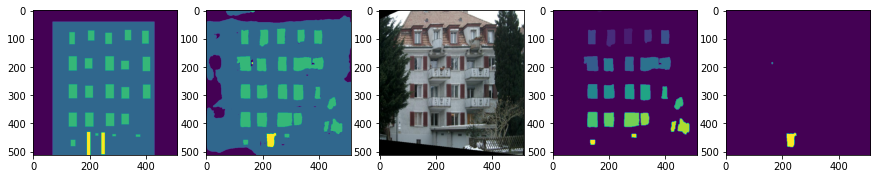

Image 92 has 24/23 windows and 2/2 pillars


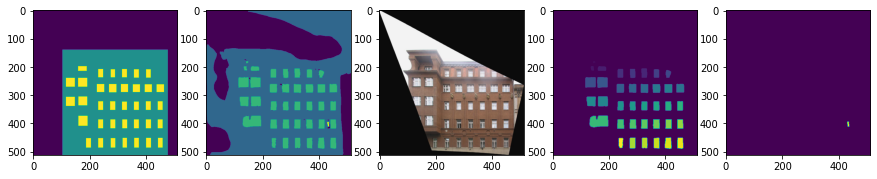

Image 113 has 37/36 windows and 1/0 pillars


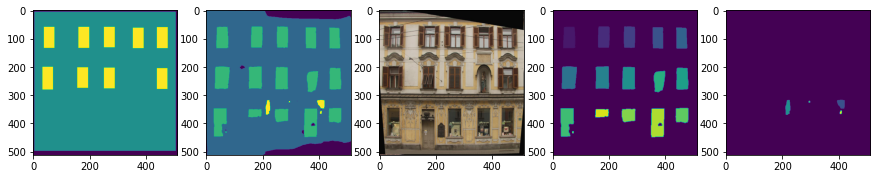

Image 34 has 16/9 windows and 4/0 pillars


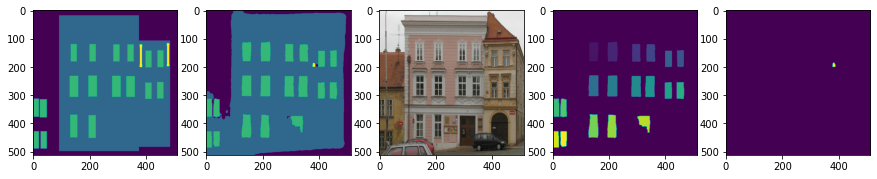

Image 110 has 19/18 windows and 1/2 pillars


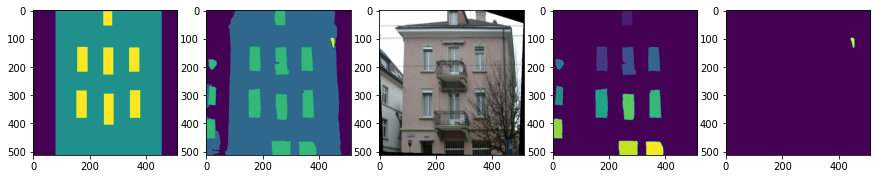

Image 138 has 12/7 windows and 1/0 pillars


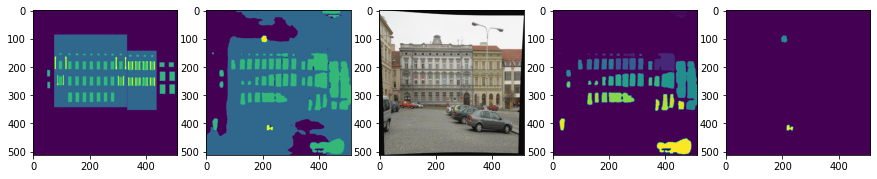

Image 109 has 45/54 windows and 2/24 pillars


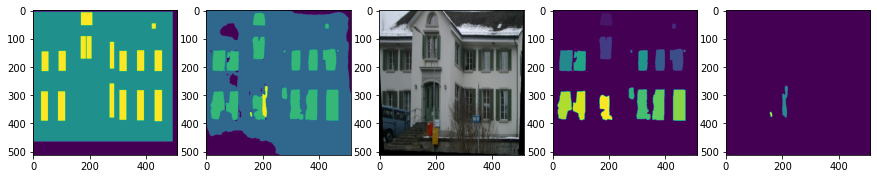

Image 136 has 17/16 windows and 2/0 pillars


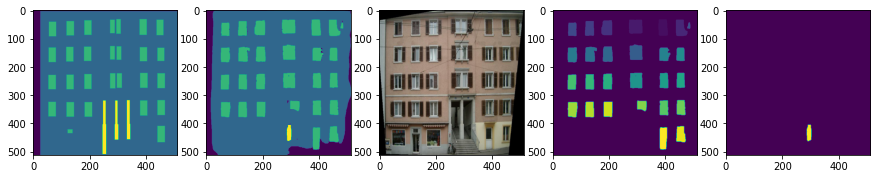

Image 79 has 27/28 windows and 1/3 pillars


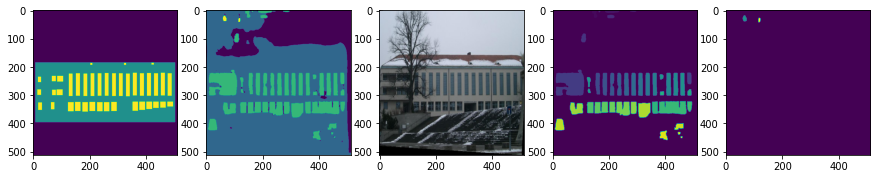

Image 141 has 40/39 windows and 2/0 pillars


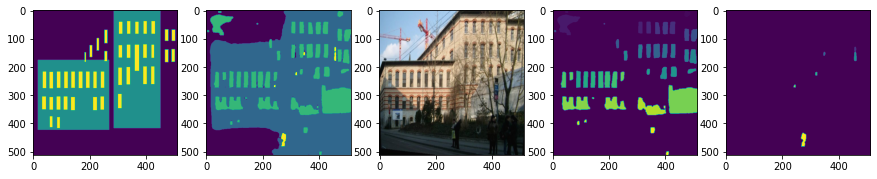

Image 128 has 44/42 windows and 6/0 pillars


In [24]:
window_index = module.val_dataset.include_classes.index("window") + 1
pillar_index = module.val_dataset.include_classes.index("pillar") + 1
samples = 10
for idx in np.random.randint(0, len(module.val_dataset), samples):
    # get prediction
    img, gt_mask = module.val_dataset[idx]
    mask = module.model(img[None, ...])
    img = module.val_dataset.unnorm(img)
    mask = mask.detach().numpy()[0]
    # normalize
    n_mask = postprocessing(mask)
    # count windows and pillars on gt and pred
    gt_windows, _ = count_objects(np.int8(gt_mask == window_index))
    gt_pillars, _ = count_objects(np.int8(gt_mask == pillar_index))
    windows, windwos_mask = count_objects(np.uint8(n_mask == window_index))
    pillars, pillars_mask = count_objects(np.uint8(n_mask == pillar_index))
    # log
    visualize_masks_pred(gt_mask, n_mask, img, windwos_mask, pillars_mask)
    print(f"Image {idx} has {windows}/{gt_windows} windows and {pillars}/{gt_pillars} pillars")